# Studying Single Particle Drifts with Charged Particle Tracing

## Table of Contents
* Introduction to Charged Particle Tracing
* The E x B Drift
* The GradB Drift
* The Curvature Drift

In [1]:
import sys

if 'google.colab' in str(get_ipython()):
    if 'plasmapy' not in sys.modules:
        !pip install plasmapy==2023.5.1 requests==2.27.1
    
%matplotlib inline

# If running locally, uncomment this line to allow dynamic plots
#%matplotlib notebook

import numpy as np
import astropy.units as u
import astropy.constants as const

import matplotlib.pyplot as plt

from plasmapy.particles import Particle
from plasmapy import formulary
from plasmapy.simulation.particle_integrators import boris_push

# Introduction to Charged Particle Tracking

A charged particle tracking code (or 'particle tracker') is a simulation tool that takes one or more particles (with defined initial conditions) and tracks their path through a space with defined properties like electric and magnetic fields. This simulation is performed iteratively, alternating between estimating the fields acting on each particle and then using those fields to calculate and update their acceleration, velocity, and position. In the first section of this notebook, we will write a basic particle tracing algorithm and then use it to visualize the gyration of a proton in a constant magnetic field. 

A very basic particle tracker could iteratively calculate the velocity and position of a particle as 

$ \large F_i = qE_i + q \vec v \times \vec B_i$

$ \large v_{i+1} = v_i + F_i/m \text{d}t$

$ \large x_{i+1} = x_i + v_i \text{d}t$

where $E_i$ and $B_i$ are the electric and magnetic fields acting on the particle at the $i$th timestep.

When coded, this function looks like this:

In [2]:
def track_particle_basic(E0, B0, x0, v0, particle, times):
    """
    This function tracks a single particle with intial position x0 and velocity v0 through the times in the
    provided array of times. The electric and magnetic fields (E0, B0) are assumed to be constant in space. 
    """

    # Initialze an array to save the trajectory and particle velocity
    x = np.zeros((times.size+1, 3))*u.m
    v = np.zeros((times.size+1, 3))*u.m/u.s
    # Set the first entry to the initial position/velocity of the particle
    x[0,:] = x0
    v[0,:] = v0

    # Calculate the simulation timestep
    dt = np.mean(np.gradient(times)).to(u.s)
    
    # Loop over all of the times in the times array
    for i, t in enumerate(times):
        # Calculate the force on the particle
        F = particle.charge * (E0 + np.cross(v[i,:], B0) )
        
        # Update the the particle velocity
        v[i+1,:] = v[i,:] + F/particle.mass*dt
        
        # Calculate the new particle position, store in the next element of the array
        x[i+1,:] = x[i,:] + v[i,:]*dt
        
    return x,v

Let's test this tracker with a simple example: a proton gyrating in a constant magnetic field. We'll put the magnetic field in the Z direction. Let's give the particle some velocity along the field (so the orbits don't overlap), but also some perpendicualar velocity so that it gyrates.

In [3]:
# Define the vector E and B fields
E0 = np.array([0,0,0]) * u.V / u.m
B0 = np.array([0,0,5])*u.T

# Define the particle (includes it's mass, charge etc.) 
# and it's position and velocity
particle = Particle('p+')
v0 = np.array([0.5,0,1])*u.m/u.s
x0 = np.array([0,0,0])*u.m

How long do we want to run the tracker for? 

If we want to visualize a number of gyrations in the magnetic field, then we should run it for several multiples of the gyroperiod! 

Similarly, if we want to resolve the gyrations (i.e. have many timesteps within one orbit), then the separation between times should be less than the gyroperiod. 

In [4]:
fci = (formulary.frequencies.gyrofrequency(np.linalg.norm(B0), particle)/2/np.pi/u.rad).to(1/u.s)
print(f"Gyroperiod: {(1/fci).to(u.ns).value:.1f} ns")

Gyroperiod: 13.1 ns


In [5]:
dt = (0.01/fci).to(u.ns).value
times = np.arange(0, (10/fci).to(u.ns).value, dt)*u.ns # Run for 10 gyroperiods, with 20 points per gyroperiod
print(f"Simulation runs for {np.max(times).to(u.ns).value:.1f} ns in steps of {dt:.2f} ns")

Simulation runs for 131.1 ns in steps of 0.13 ns


Now we can put these values into the function to track the particle

In [6]:
x,v = track_particle_basic(E0, B0, x0, v0, particle, times)

The following two functions will visualize the results.

*Note: If you're running this Jupyter notebook locally the 3D plots should be interactive, so you can click and drag to rotate the view. If you are running this notebook in the cloud (for example on Google Colaboratory) this may not work.*

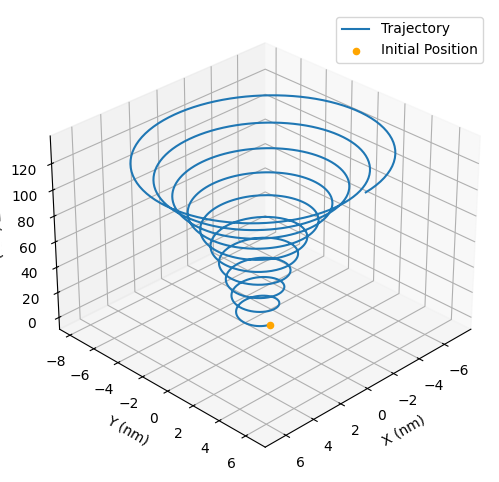

In [7]:
def plot3D(x, view=None):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    
    # Set the initial view angle
    if view is not None:
        ax.view_init(*view)

    # Plot the orbit
    ax.plot(x[:,0].to(u.nm).value, x[:,1].to(u.nm).value, x[:,2].to(u.nm).value, label="Trajectory")
    
    # Plot the initial position of the particle
    ax.scatter(x[0,0].to(u.nm).value, x[0,1].to(u.nm).value, x[0,2].to(u.nm).value, 
               label='Initial Position', color='orange')
   
    ax.set_xlabel("X (nm)")
    ax.set_ylabel("Y (nm)")
    ax.set_zlabel("Z (nm)")
    ax.legend();
    
    return ax

# The view keyword specifies the (elevation angle, azimuthal angle, roll angle) in degrees
plot3D(x, view=(30,45,0));

Wait - that doesn't look right, does it? The gyroradius should be constant, so the circles should all be the same size! Instead, we see them increasing in time.

The problem is that our simple particle tracker is not conserving energy, which we can see by plotting the kinetic energy of the particle as a function of time.

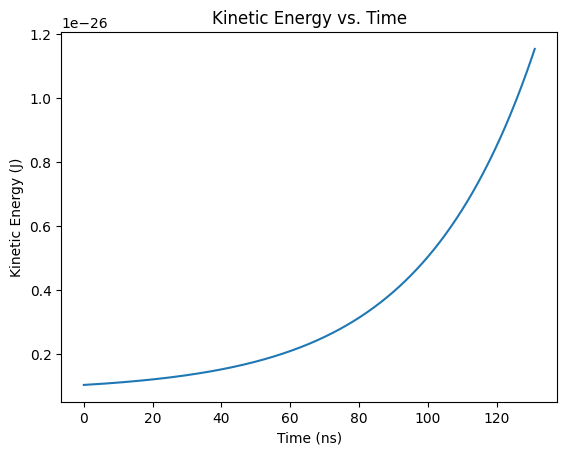

In [8]:
def plotKE(times, particle, v):
    KE = 0.5*particle.mass*np.linalg.norm(v, axis=-1)**2
    
    fig, ax = plt.subplots()
    ax.plot(times.to(u.ns).value, KE.to(u.J).value[:-1])
    ax.set_title("Kinetic Energy vs. Time")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Kinetic Energy (J)");

plotKE(times, particle, v)

Since a magnetic field alone can do not work on the particle, the particle's energy should be constant, not increasing!

It turns out$^1$ that the problem is that updating the particle velocity and position within one timestep is not precise enough. Instead, we need to use a more advanced algorithm called the Boris Push. This function is implemented in PlasmaPy, so we can just import it into a new tracking function.


*$^1$For more details, see Birdsall & Langdon "Plasma Physics via Computer Simulations" (2004)*

In [9]:
def track_particle_boris(E0, B0, x0, v0, particle, times):
    """
    This function tracks a single particle with intial position x0 and velocity v0 through the times in the
    provided array of times. The electric and magnetic fields (E0, B0) are assumed to be constant in space. 
    """

    # Initialze an array to save the trajectory and particle velocity
    x = np.zeros((times.size+1, 3))*u.m
    v = np.zeros((times.size+1, 3))*u.m/u.s
    # Set the first entry to the initial position/velocity of the particle
    x[0,:] = x0
    v[0,:] = v0

    # Calculate the simulation timestep
    dt = np.mean(np.gradient(times)).to(u.s)
    
    # Loop over all of the times in the times array
    for i, t in enumerate(times):
        # The Boris push function advances the particles in a way that conserves kinetic energy
        # This function is part of PlasmaPy
        _x = x[i,:].to(u.m).value
        _v = v[i,:].to(u.m/u.s).value
        boris_push(_x, 
                   _v, 
                   np.array([B0.to(u.T).value,]),
                   np.array([E0.to(u.V/u.m).value,]),
                   particle.charge.to(u.C).value,
                   particle.mass.to(u.kg).value,
                   dt.to(u.s).value)
        x[i+1,:]=_x*u.m
        v[i+1, :] =_v*u.m/u.s
        
    return x,v

Now let's try running the same particle through the new tracker.

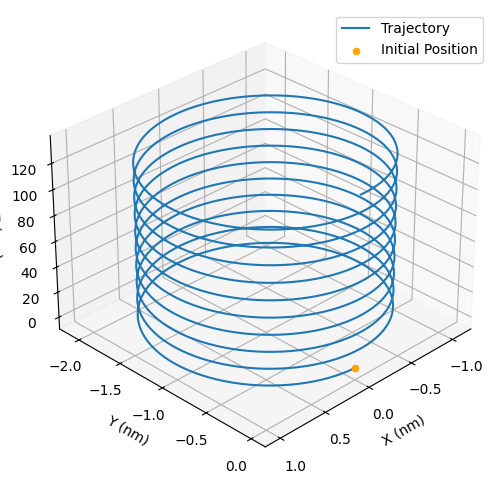

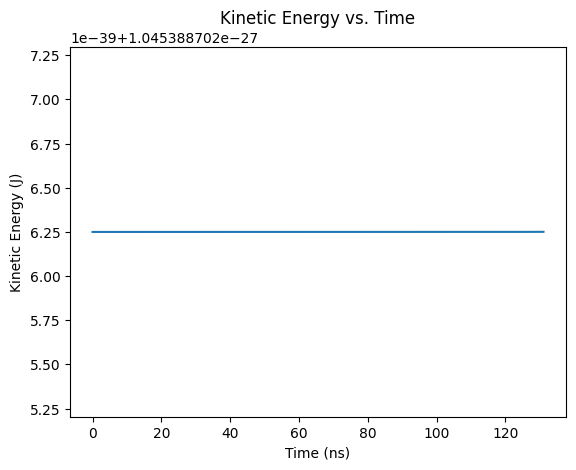

In [10]:
x,v = track_particle_boris(E0, B0, x0, v0, particle, times)
plot3D(x, view=(30,45,0))
plotKE(times, particle, v);

Much better! The particle energy is now conserved, and as a result the gyrorbits remain the same size.

Before we proceed to some more complex examples, we need to add one more feature to the particle tracer: the ability to handle fields that vary in space. In order to define these fields, we first need to define a grid of spatial coordinates. 

How big should we make the grid? We want the particle to stay on the grid throughout the entire gyration, so the x and y axes need to be larger than the Larmor radius.

In [11]:
rLarmor = formulary.lengths.gyroradius(np.linalg.norm(B0), particle, Vperp=v0[0]) 
print(f"rLarmor: {rLarmor.to(u.nm).value:.2f} nm")

rLarmor: 1.04 nm


In the z-direction, we know that the final z position of the particle will be $v_z t_{max}$, so we'd better make the array a little longer than that so the particle doesn't leave the grid.

In [12]:
zmax = (v0[2]*times[-1]).to(u.nm)
print(f"Zmax: {zmax.to(u.nm).value:.2f} nm")

Zmax: 131.06 nm


In [13]:
xaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100)
yaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100)
zaxis = np.linspace(0*u.nm, 1.2*zmax, num=100)
X, Y, Z = np.meshgrid(xaxis, yaxis, zaxis, indexing='ij')

Now fields can be defined as vector arrays that have a value at each vertex of the grid. Let's start by re-creating the example of a constant B field and zero E field. 

Each of these arrays has the shape `E.shape = (n_xpos, n_ypos, n_zpos, 3)`

In [14]:
# Create grids of fields to go on the spatial grid
E = np.zeros((*X.shape, 3))*u.V/u.m

B = np.zeros((*X.shape, 3))*u.T
B[:,:,:, 2] = 5*u.T

Then finally we need to add the grid to the particle tracker and add some lines to estimate the fields acting on the particle at a given position. 

The approximation of a value from a discrete grid at a given continuous position like this is called interpolation, and there are many sophisticated algorithms for doing it. For the sake of simplicity, we will use the "nearest neighbor" algorithm, which just assumes that the fields on the particle are equal to those on the nearest grid vertex. 

In [15]:
def track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times):
    """
    This function tracks a single particle with intial position x0 and velocity v0 through the times in the
    provided array of times. The electric and magnetic fields (E0, B0) are assumed to be constant in space. 
    """

    # Initialze an array to save the trajectory and particle velocity
    x = np.zeros((times.size+1, 3))*u.m
    v = np.zeros((times.size+1, 3))*u.m/u.s
    # Set the first entry to the initial position/velocity of the particle
    x[0,:] = x0
    v[0,:] = v0
    
    

    # Calculate the simulation timestep
    dt = np.mean(np.gradient(times)).to(u.s)
    
    # Loop over all of the times in the times array
    for i, t in enumerate(times):
        
        # Locate the nearest grid cell to the particle ('nearest neighbor' interpolation)
        xi = np.argmin(np.abs(x[i,0] - xaxis))
        yi = np.argmin(np.abs(x[i,1] - yaxis))
        zi = np.argmin(np.abs(x[i,2] - zaxis))
        
        # Get the E and B fields at the current particle location
        _E = np.array([E[xi, yi, zi, :].to(u.V/u.m).value,])
        _B = np.array([B[xi, yi, zi, :].to(u.T).value,])
        
        # The Boris push function advances the particles in a way that conserves kinetic energy
        # This function is part of PlasmaPy
        _x = x[i,:].to(u.m).value
        _v = v[i,:].to(u.m/u.s).value
        boris_push(_x, _v, _B, _E,
                   particle.charge.to(u.C).value,
                   particle.mass.to(u.kg).value,
                   dt.to(u.s).value)
        x[i+1,:]=_x*u.m
        v[i+1, :] =_v*u.m/u.s
        
    return x,v

Running the new tracker gives us the same results as before (as expected).

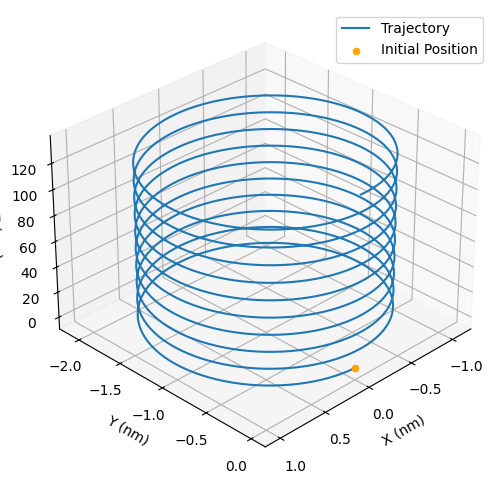

In [16]:
x,v = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)
plot3D(x, view=(30,45,0));

We will use this final tracker function for the remainder of the examples in this notebook.

# The ExB Drift

The ExB drift occurs when a charged particle moves through perpendicular E and B fields. In this example, we will calculate the ExB velocity for the particle defined below.

In [17]:
# Define strengths for the E and B fields
E0 = 0.1 * u.V / u.m
B0 = 5*u.T
particle = Particle('p+')

We can use a function from the PlasmaPy Formulary module to calculate the expected magnitude of the ExB drift velocity in these fields:

In [18]:
v_ExB = formulary.drifts.ExB_drift(E0*np.array([0,1,0]), B0*np.array([0,0,1]))
print(f"ExB Velocity: {v_ExB}")

ExB Velocity: [0.02 0.   0.  ] m / s


Now let's run a particle tracking simulation to confirm this estimate. First we will define the particles initial velocity and positon. 

We'll chose the intial position so the gyrocenter is at (x,y)=(0,0). We'll give the particle some perpendicular velocity and a paralell velocity, so it orbits while drifting along the field.

In [19]:
v0 = np.array([0.5,0,1])*u.m/u.s
x0 = np.array([0, rLarmor.to(u.m).value, 0])*u.m

As in the introduction above, we will define a grid and time array over which to run the simulation, using the gyroperiod and gyroradius to help chose an appropriate domain.

In [20]:
fci = (formulary.frequencies.gyrofrequency(np.linalg.norm(B0), particle)/2/np.pi/u.rad).to(1/u.s)
times = np.arange(0, (20/fci).to(u.s).value, (1/fci/100).to(u.s).value)*u.s

In [21]:
rLarmor = formulary.lengths.gyroradius(np.linalg.norm(B0), particle, Vperp=v0[0]) 
xaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100)
yaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100)
zaxis = np.linspace(0, 1.2*v0[2]*times[-1], num=100)
X, Y, Z = np.meshgrid(xaxis, yaxis, zaxis, indexing='ij')

Finally, we need to create grids of fields at each of these positions. As in the introduction, the fields are constant everywhere so these arrays have the same vector value at each point.

In [22]:
# Create grids of fields to go on the spatial grid
E = np.zeros((*X.shape, 3))*u.V/u.m
E[..., 1] = E0

B = np.zeros((*X.shape, 3))*u.T
B[..., 2] = B0

In [23]:
# Call the function on our particle + fields
x,v = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)

Done! Now we can visualize the results. First, let's plot the evolution of the coordinates of the particle in time. We see that 

- The ExB drift moves the particle in the X direction.
- The particle gyrates around it's gyrocenter in the XY plane.
- The particle moves with constant velocity in the Z direction. 

Notice how the gyrocenter of the particle in the X direction follows the line predicted by the ExB velocity we calcualted using  the PlasmaPy formulary function. 

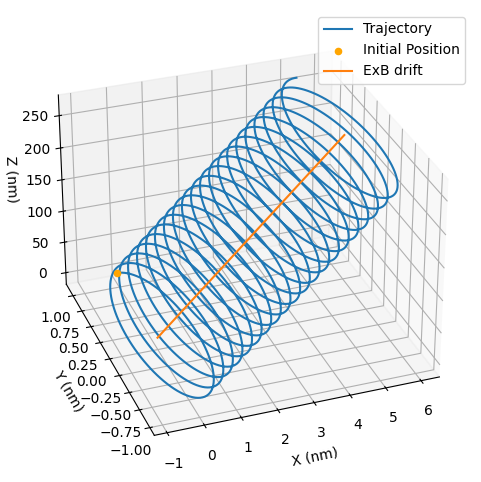

In [24]:
ax = plot3D(x,view=(30,250,0))

# Overplot the theoretical ExB guiding center motion
# Plot the theoretical drift
x_final = (times[-1]*(v_ExB + np.array([0,0,v0[2].value])*v0.unit)).to(u.nm).value

ax.plot([0,x_final[0]], [0,x_final[1]], [0,x_final[2]], label='ExB drift')
ax.legend();

It's also helpful to visualize the change in each coordinate as a function of time.

Notice how the x position (blue) is gyrating around the position predicted by the theoretical ExB drift velocity. The predicted velocity is the *guiding center drift*, meaning that it represents the motion of the center of the particle's gyration.

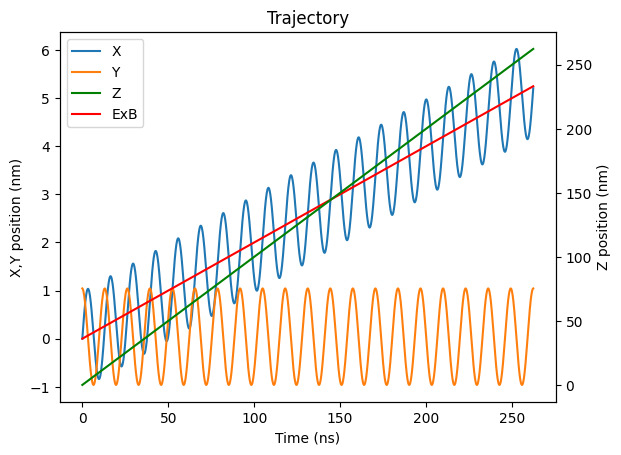

In [25]:
fig, ax = plt.subplots()
ax.set_title("Trajectory")
ax.set_xlabel("Time (ns)")

ax.plot(times.to(u.ns).value, x[:-1, 0].to(u.nm).value, label='X')
ax.plot(times.to(u.ns).value, x[:-1, 1].to(u.nm).value, label='Y')
ax.plot([], [], color='green', label='Z')
ax.plot(times.to(u.ns).value, (v_ExB[0]*times).to(u.nm).value, color='red', label='ExB')
ax.set_ylabel("X,Y position (nm)")

ax2 = ax.twinx()
ax2.plot(times.to(u.ns).value, x[:-1, 2].to(u.nm).value, label='Z', color='green')
ax2.set_ylabel("Z position (nm)");
ax.legend();

# The $\nabla$ B Drift

The gradient B drift causes the guiding center of a gyrating particle to drift along a gradient in the ambient magnetic field. 

$\Large v_{\nabla B} = \frac{m v_\perp^2}{2qB} \frac{\vec B \times \nabla B}{B^2}$

We'll start by defining a particle as before.

In [26]:
particle = Particle('p+')
v0 = np.array([.5,0,0])*u.m/u.s
x0 = np.array([0, 0, 0])*u.m

Now we need a grid of fields with a magnetic field gradient. 

In [27]:
gradB = -0.5*u.T/u.nm
B0 = 6*u.T

# Create the grid
rLarmor = formulary.lengths.gyroradius(B0, particle, Vperp=v0[0]) 
xaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100)
yaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100)
zaxis = np.linspace(0, 1.2*v0[2]*times[-1], num=100)
X, Y, Z = np.meshgrid(xaxis, yaxis, zaxis, indexing='ij')

B = np.zeros((*X.shape, 3))*u.T
B[..., 2] = (B0 - gradB*X)

E = np.zeros((*X.shape, 3))*u.V/u.m

The following plot confirms that the magnetic field is constant in Y and Z, but has a gradient in X.

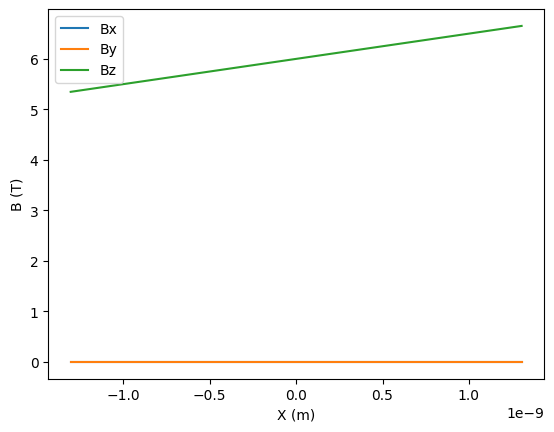

In [28]:
fig, ax = plt.subplots()
ax.plot(xaxis, B[:,50,50,0], label='Bx')
ax.plot(xaxis, B[:,50,50,1], label='By')
ax.plot(xaxis, B[:,50,50,2], label='Bz')
ax.set_xlabel("X (m)")
ax.set_ylabel("B (T)")
ax.legend();

Now we need to set up the time axis again. This time, since B is changing, we'll use the minimum gyroperiod across the entire domain to make sure we always resolve the gyration.

In [29]:
min_fci = formulary.frequencies.gyrofrequency(np.min(B[...,2]), particle)/2/np.pi/u.rad
times = np.arange(0, (20/min_fci).to(u.s).value, (1/min_fci/100).to(u.s).value)*u.s

Now we can call the particle tracking function

In [30]:
x,v = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)

In addition to the gyration and the velocity of the particle in the z direction, the particle now also has a drift in the y direction, which is the direction perpendicular to both B and gradB.

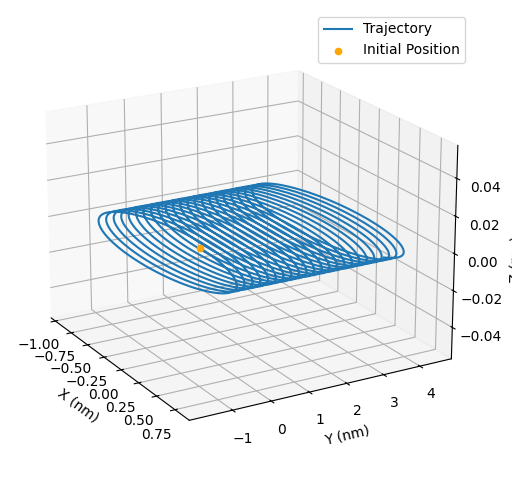

In [31]:
ax = plot3D(x, view=(20,-30,0))

In the 2D and 3D plots we see the expected behavior: the particle gyrates in the XY plane, but the gradB drift results in a guiding center motion in the +Y direction. We can see this clearly by plotting each coordinate as a function of time.

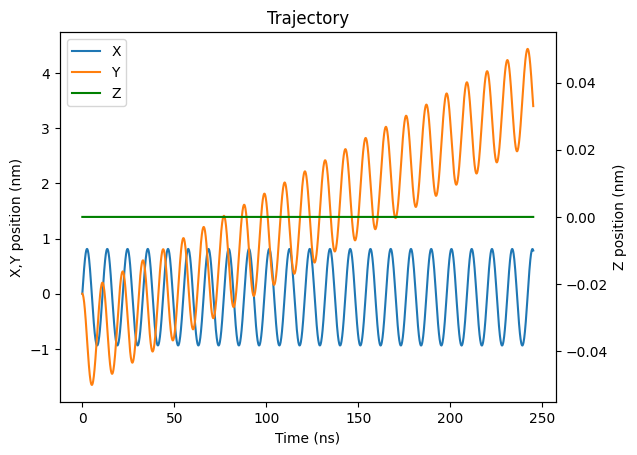

In [32]:
fig, ax = plt.subplots()
ax.set_title("Trajectory")
ax.set_xlabel("Time (ns)")

ax.plot(times.to(u.ns).value, x[:-1, 0].to(u.nm).value, label='X')
ax.plot(times.to(u.ns).value, x[:-1, 1].to(u.nm).value, label='Y')
ax.plot([], [], color='green', label='Z')
ax.set_ylabel("X,Y position (nm)")

ax2 = ax.twinx()
ax2.plot(times.to(u.ns).value, x[:-1, 2].to(u.nm).value, label='Z', color='green')
ax2.set_ylabel("Z position (nm)");
ax.legend();

# The Curvature Drift

The curvature drift occurs when particles travel through a region of curved magnetic field. 

$ \Large v_R = \frac{m v_\parallel}{q B^2} \frac{\vec R_c \times \vec B}{R_c^2}$

where $\vec R_c$ is the vector pointing towards the center of curvature. If we have a magnetic field in the $\hat z$ direction with curvature in the $\hat x$ direction, then we will expect to see a drift in the $\hat y$ direction. 

However, geometrically a curved magnetic field also always has a non-zero magnetic field, so in this simulation we will observe the sum of the two drifts (which are in the same direction)

$\Large v_{R} + \Large v_{\nabla B} = \frac{m}{q} \frac{\vec R_c \times \vec B}{R_c^2 B^2} \bigg (
v_\parallel^2 + \frac{1}{2} v_\perp^2 \bigg ) $


As before, let's start by defining a particle.

In [33]:
particle = Particle('p+')

v0 = np.array([.01,0,0])*u.m/u.s
x0 = np.array([-2e-9, 0, 0])*u.m

Next we'll define our field grid. We will create a magnetic field with curvature by defining a center of curvature off of the plane, defining the field in cylindrical coordinates, then calculating the Cartesian components.

In [34]:
R_curvature =100*u.nm
B0 = 5*u.T

# Create the grid
xaxis = np.linspace(-1.5*u.nm, 1.5*u.nm, num=100)
yaxis = np.linspace(-1.5*u.nm, 1.5*u.nm, num=100)
zaxis = np.linspace(0, 1.5*u.nm, num=100)
X, Y, Z = np.meshgrid(xaxis, yaxis, zaxis, indexing='ij')

B = np.zeros((*X.shape, 3))*u.T
theta = np.arctan2( (Y -R_curvature).to(u.m).value/10, X.to(u.m).value)
B[...,0] = -np.sin(theta)*B0
B[...,1] = np.cos(theta)*B0

E = np.zeros((*X.shape, 3))*u.V/u.m

This is a bit of a tricky field, so let's make a vector plot to visualize it

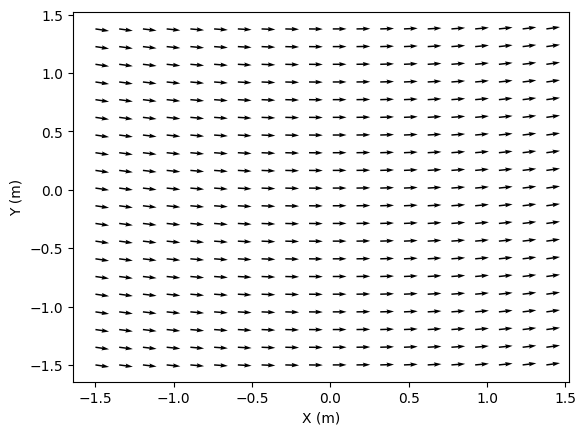

In [35]:
fig, ax = plt.subplots()
step=5
ax.quiver(X[::step,::step, 50], Y[::step, ::step, 50], 
          B[::step,::step, 50, 0].value, B[::step, ::step, 50, 1].value);
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)");

As before, we'll create a time array based on the maximum magnetic field

In [36]:
fci = formulary.frequencies.gyrofrequency(np.max(np.linalg.norm(B, axis=-1)), particle)/2/np.pi/u.rad
times = np.arange(0, (20/fci).to(u.s).value, (1/fci/100).to(u.s).value)*u.s

In [37]:
# Call the function on our particle + fields
x,v = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)

Now let's plot the results. The curvature drift and gradient B leads to a drift in the Y direction (R_curvature X B) superimposed on the initial velocity we gave the particle in the X direction. 

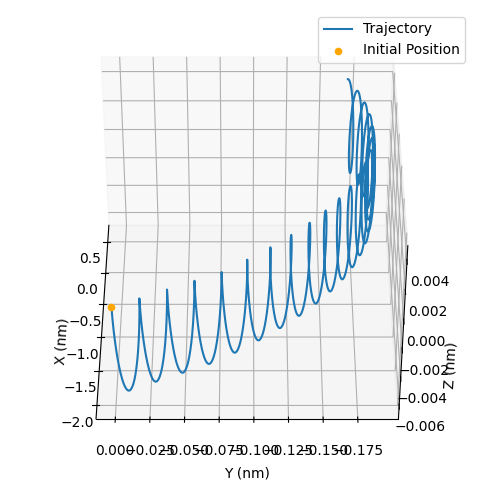

In [38]:
plot3D(x, view=(40,180,0));

And, as before, here are the individual coordinates plotted.

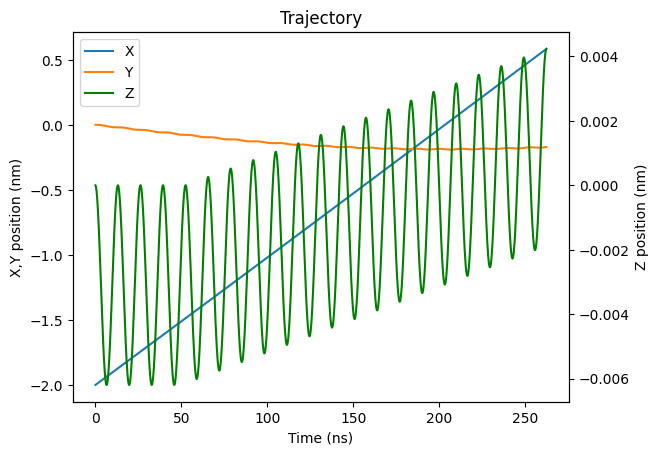

In [39]:
fig, ax = plt.subplots()
ax.set_title("Trajectory")
ax.set_xlabel("Time (ns)")

ax.plot(times.to(u.ns).value, x[:-1, 0].to(u.nm).value, label='X')
ax.plot(times.to(u.ns).value, x[:-1, 1].to(u.nm).value, label='Y')
ax.plot([], [], color='green', label='Z')
ax.set_ylabel("X,Y position (nm)")

ax2 = ax.twinx()
ax2.plot(times.to(u.ns).value, x[:-1, 2].to(u.nm).value, label='Z', color='green')
ax2.set_ylabel("Z position (nm)");
ax.legend();